# Imports

In [1]:
import csv, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import scipy
from geopy import distance

# Globals

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]

LORA_FREQ = 868  # LoRa frequency in MHz
EIRP_AND_RX_GAIN_LOSS = 14 + 3 - 2  # Tx + Rx Antenna Gain - Rx cable loss
SENSOR_HEIGHT = 2  # in m

# Load Data

In [3]:
gw = pd.read_csv('gateways.csv', index_col='id')
df = pd.concat([pd.read_csv('samples.csv'), pd.read_csv('signalserver.csv')], axis=1)
df

,latitude,longitude,transceived_at,pkt_number,rssi,snr,gw,ecc33,cost_hata,ericcson,egli,itm,itwom
0,50.720277,7.108348,2021-01-29,17343,-120,-18.8,090e,140.61,136.85,139.37,162.70,162.70,127.26
1,50.716624,7.113756,2021-01-29,17335,-122,-1.5,090e,142.16,137.87,141.77,171.41,171.41,136.56
2,50.715943,7.114189,2021-01-29,17334,-120,-6.0,090e,142.81,138.30,142.78,151.37,151.37,114.15
3,50.716847,7.112487,2021-01-29,17331,-120,-5.8,090e,142.40,138.03,142.14,129.28,129.28,110.22
4,50.718797,7.110078,2021-01-29,17327,-120,-11.8,090e,141.29,137.30,140.42,194.15,194.15,128.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131052,50.732904,7.077093,2020-08-03,690,-120,-12.5,01c6,142.31,137.89,143.68,150.82,150.82,123.99
131053,50.735232,7.075249,2020-08-03,689,-118,-1.8,01c6,138.65,135.61,138.35,126.33,126.33,110.78
131054,50.734703,7.076780,2020-08-03,687,-118,-10.0,01c6,139.97,136.43,140.26,124.97,124.97,114.80
131055,50.733181,7.076455,2020-08-03,686,-116,-12.8,01c6,141.75,137.54,142.86,118.58,118.58,110.49


# Pre-Processing

## Calculate distances to gateway

In [4]:
df['gw_distance_m'] = df.apply(lambda row: round(distance.distance(
        (row.latitude, row.longitude), (gw.loc[row.gw].latitude, gw.loc[row.gw].longitude)).m), axis=1)
df['gw_distance_rounded_km'] = df.apply(lambda row: round(row.gw_distance_m/1000, 2), axis=1)

## Calculate Received Packet Power (RPP)

In [5]:
df['rpp'] = df.apply(lambda row: row.rssi + min(row.snr, 0), axis=1)

## Calculate sample Path Loss

In [6]:
df['path_loss'] = df.apply(lambda row: EIRP_AND_RX_GAIN_LOSS - row.rpp, axis=1)

## Calculate Path Loss Models

###  Free Space Path Loss (FSPL)

In [7]:
df['fspl'] = df.apply(
    lambda row: 20 * np.log10(row.gw_distance_m) + 20 * np.log10(LORA_FREQ) - 27.55, axis=1)

### Log-Distance Path Loss (LDPL)

In [8]:
def log_distance_path_loss(distance, pl0, n):
    return pl0 + 10 * n * np.log10(distance)

df['ldpl_dortmund'] = df.apply(
    lambda row: log_distance_path_loss(row.gw_distance_m/1000, 132.25, 2.65), axis=1)

df['ldpl_oulu'] = df.apply(
    lambda row: log_distance_path_loss(row.gw_distance_m/1000, 128.95, 2.32), axis=1)

df['ldpl_ghent'] = df.apply(
    lambda row: log_distance_path_loss(row.gw_distance_m, 74.85, 2.75), axis=1)

### LDPL Curve-Fitting

In [9]:
def calc_opt_ldpl_params(sample_size=None, max_distance=None):
    if sample_size: d = df.sample(n=sample_size)
    else:           d = df
    if max_distance:
        d = d[d.gw_distance_rounded_km < max_distance]
    grp_by_dist = d.groupby(by='gw_distance_rounded_km')
    return scipy.optimize.curve_fit(log_distance_path_loss, 
        list(grp_by_dist.groups.keys()), EIRP_AND_RX_GAIN_LOSS - grp_by_dist.rpp.median().values,
        method='lm')[0]

ldpl_opt_fl0, ldpl_opt_n = calc_opt_ldpl_params()
print(f'fl0: {ldpl_opt_fl0} n: {ldpl_opt_n}')

df['ldpl_curve_fit'] = df.apply(
    lambda row: log_distance_path_loss(row.gw_distance_m/1000, ldpl_opt_fl0, ldpl_opt_n), axis=1)

fl0: 132.47697039582516 n: 1.60219872347594


### Beirut Loss Modell

In [10]:
df['beirut'] = df.apply(
    lambda row: 10 * 4.18 * np.log10(row.gw_distance_m/1000) + 120.86 - 
        6.3 * np.log10(gw.loc[row.gw].antenna_height), axis=1)

### Okumura–Hata 


In [11]:
df['okumura_hata'] = df.apply(
    lambda row:
        69.55 + 26.16 * np.log10(LORA_FREQ) - 13.82 * np.log10(gw.loc[row.gw].antenna_height) - 
        (0.8 + (1.1 * np.log10(LORA_FREQ) - 0.7) * SENSOR_HEIGHT - 1.56 * np.log10(LORA_FREQ)) + 
        (44.9 - 6.55 * np.log10(gw.loc[row.gw].antenna_height)) * np.log10(row.gw_distance_m / 1000),
    axis=1)

### Winner+

In [12]:
df['winnerplus'] = df.apply(
    lambda row:
        (44.9 - 6.55 * np.log10(gw.loc[row.gw].antenna_height)) * np.log10(row.gw_distance_m) + 
        5.83 * np.log10(gw.loc[row.gw].antenna_height) + 16.33 + 26.16 * np.log10(LORA_FREQ/1000),
    axis=1)

In [13]:
df.head()

,latitude,longitude,transceived_at,pkt_number,rssi,snr,gw,ecc33,cost_hata,ericcson,...,rpp,path_loss,fspl,ldpl_dortmund,ldpl_oulu,ldpl_ghent,ldpl_curve_fit,beirut,okumura_hata,winnerplus
0,50.720277,7.108348,2021-01-29,17343,-120,-18.8,090e,140.61,136.85,139.37,...,-138.8,153.8,98.151366,141.433537,136.989927,166.880085,138.029367,127.759774,141.326892,145.607545
1,50.716624,7.113756,2021-01-29,17335,-122,-1.5,090e,142.16,137.87,141.77,...,-123.5,138.5,98.623251,142.058785,137.537314,167.528928,138.407394,128.746015,142.200188,146.480840
2,50.715943,7.114189,2021-01-29,17334,-120,-6.0,090e,142.81,138.30,142.78,...,-126.0,141.0,98.820999,142.320802,137.766702,167.800832,138.565810,129.159308,142.566150,146.846803
3,50.716847,7.112487,2021-01-29,17331,-120,-5.8,090e,142.40,138.03,142.14,...,-125.8,140.8,98.697017,142.156525,137.622883,167.630356,138.466488,128.900186,142.336703,146.617355
4,50.718797,7.110078,2021-01-29,17327,-120,-11.8,090e,141.29,137.30,140.42,...,-131.8,146.8,98.356204,141.704947,137.227539,167.161738,138.193463,128.187885,141.705976,145.986628


### Strongest Samples only

In [14]:
grp_by_cols = ['latitude','longitude', 'transceived_at', 'pkt_number']
df_strongest = df.copy()
df_strongest['gw_count'] = df_strongest.groupby(grp_by_cols)[grp_by_cols[0]].transform('size')
df_strongest = df_strongest                                   \
                .sort_values('rpp')                           \
                .drop_duplicates(grp_by_cols, keep='last')    \
                .reset_index(drop=True)
df_strongest

,latitude,longitude,transceived_at,pkt_number,rssi,snr,gw,ecc33,cost_hata,ericcson,...,path_loss,fspl,ldpl_dortmund,ldpl_oulu,ldpl_ghent,ldpl_curve_fit,beirut,okumura_hata,winnerplus,gw_count
0,50.654471,7.187662,2021-03-01,18535,-124,-19.8,0172,165.94,154.06,181.58,...,158.8,106.810881,152.907395,147.034965,178.786919,144.966499,146.645276,159.717207,163.997859,1
1,50.748076,7.138715,2021-02-22,17565,-124,-19.2,090e,130.27,130.42,124.30,...,158.2,95.154969,137.463311,133.514106,162.760040,135.628955,121.497305,135.781608,140.062261,1
2,50.740231,7.092159,2020-10-19,6695,-123,-20.0,015c,138.82,135.69,136.96,...,158.0,97.726602,140.870725,136.497201,166.296035,137.689089,126.872018,140.540803,144.821455,1
3,50.746981,7.178866,2021-02-03,16010,-124,-19.0,090e,154.72,146.62,162.28,...,158.0,102.710280,147.474098,142.278267,173.148592,141.681510,137.287905,149.763850,154.044502,1
4,50.719577,7.057675,2020-10-07,6674,-123,-19.5,015c,138.65,135.58,136.70,...,157.5,97.656504,140.777845,136.415887,166.199651,137.632934,126.725513,140.411076,144.691729,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56535,50.736874,7.073773,2020-11-03,8299,-71,7.5,06df,19.85,103.20,70.05,...,86.0,85.803690,125.072867,122.666623,149.902032,128.137652,98.574803,112.016062,116.296715,5
56536,50.742870,7.066882,2020-10-15,6479,-71,8.0,08d5,78.21,108.83,74.00,...,86.0,85.234469,124.318649,122.006326,149.119352,127.681649,101.128809,118.109990,122.390642,4
56537,50.736460,7.074291,2021-01-22,16716,-71,10.2,06df,4.75,101.04,64.99,...,86.0,84.790762,123.730737,121.491626,148.509255,127.326196,96.457783,110.319376,114.600029,5
56538,50.735867,7.073481,2020-11-02,8690,-71,9.5,06df,5.42,101.13,65.21,...,86.0,84.845219,123.802893,121.554797,148.584134,127.369822,96.571599,110.410593,114.691246,2


# Analysis

## Rx Gateways

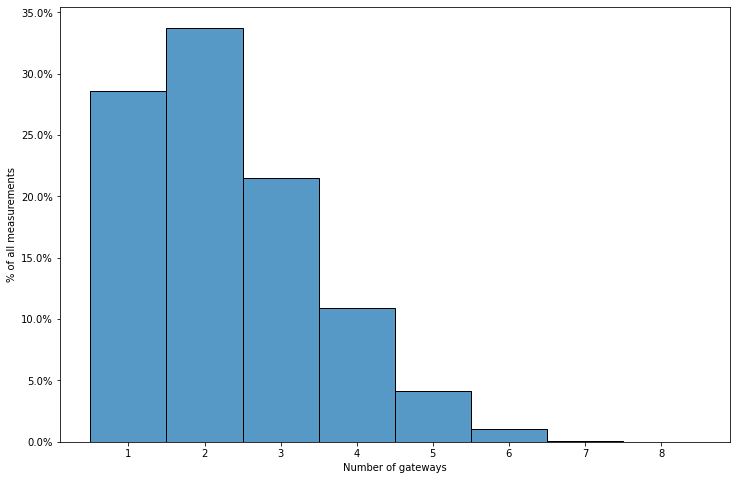

In [15]:
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots()
sns.histplot(df_strongest, x='gw_count', stat='density', discrete=True, ax=ax) \
    .set(xlabel='Number of gateways', ylabel='% of all measurements')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show(fig)

## CDF of Curve Fitting deviation

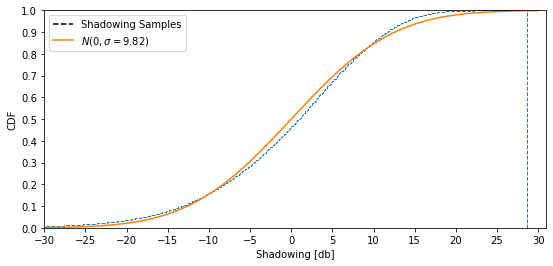

In [16]:
def plot_curve_fit_cdf():
    d = df.path_loss - df.ldpl_curve_fit
    
    fig, ax = plt.subplots()
    ax.hist(d, cumulative=True, density=True, bins=500, histtype='step', linestyle='dashed')
    ax.plot([0], [0], color='black', linestyle='dashed', label='Shadowing Samples')  # dummy

    x_size = 30
    x = np.linspace(-x_size, x_size, 1000)
    mu = 0
    sigma = round(d.std(ddof=0), 2)
    ax.plot(x, scipy.stats.norm.cdf(x, mu, sigma), linestyle='solid', label=f'$N({mu},\sigma={sigma}$)')

    ax.set_xticks(np.arange(-x_size, x_size+1, 5))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xlabel('Shadowing [db]')
    ax.set_ylabel('CDF')
    ax.set_xlim([-x_size, x_size+1])
    ax.set_ylim([0, 1])
    ax.legend(loc='upper left')

    plt.show()

plot_curve_fit_cdf()

## Curve Fitting Progression

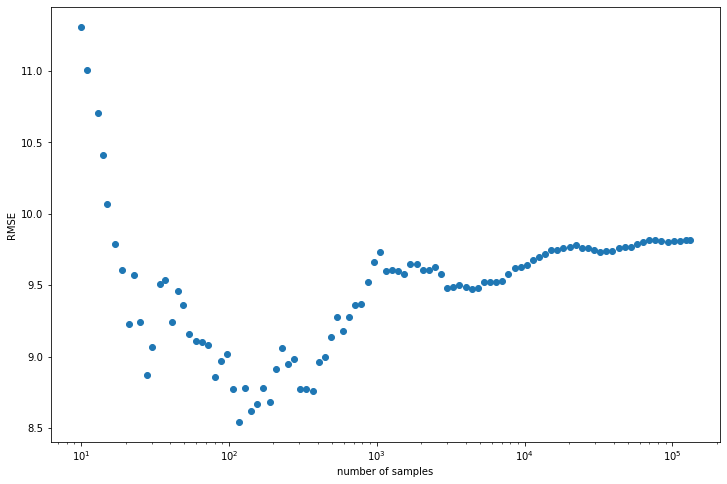

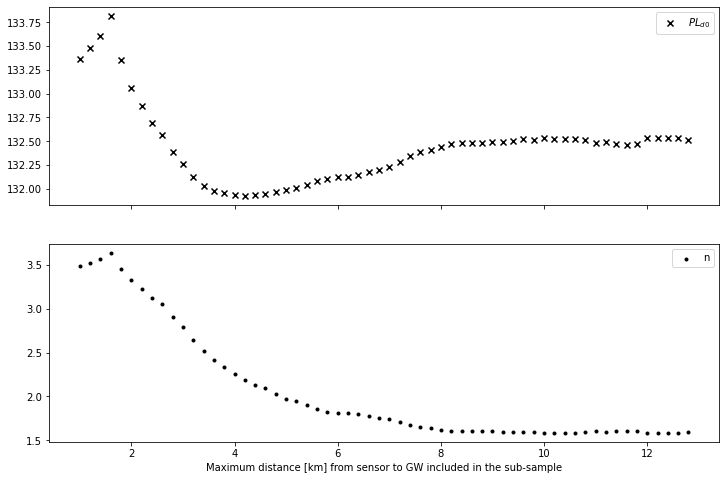

In [17]:
root_mean_squared_error = lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False)

def plot_fitting_rmse_progression():
    x = list(set([ max(10, int(1.1**i)) for i in range(2,int(math.log(len(df.index),1.1))+1) ] + [len(df.index) ]))
    y = []
    for n in x:
        d = df.sample(n, random_state=42323347)
        y.append(round(root_mean_squared_error(d.rpp, EIRP_AND_RX_GAIN_LOSS - d.ldpl_curve_fit), 2))
    fig, ax = plt.subplots()
    ax.scatter(x,y)
    ax.set_xscale('log')
    ax.set_xlabel('number of samples')
    ax.set_ylabel('RMSE')
    plt.show(fig)
    
def plot_fitting_values_per_distance():
    x = np.arange(1, df.gw_distance_rounded_km.max(), 0.2)
    y = [ calc_opt_ldpl_params(max_distance=d) for d in x ]
    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
    p1 = ax.scatter(x,[fl0 for fl0,_ in y], label='$PL_{d0}$', color='black', marker='x')
    p2 = ax2.scatter(x,[n for _,n in y], label='n', color='black', marker='.')
    ax2.set_xlabel('Maximum distance [km] from sensor to GW included in the sub-sample')
    ax.legend(); ax2.legend()
    plt.show(fig)
    
plot_fitting_rmse_progression()
plot_fitting_values_per_distance()

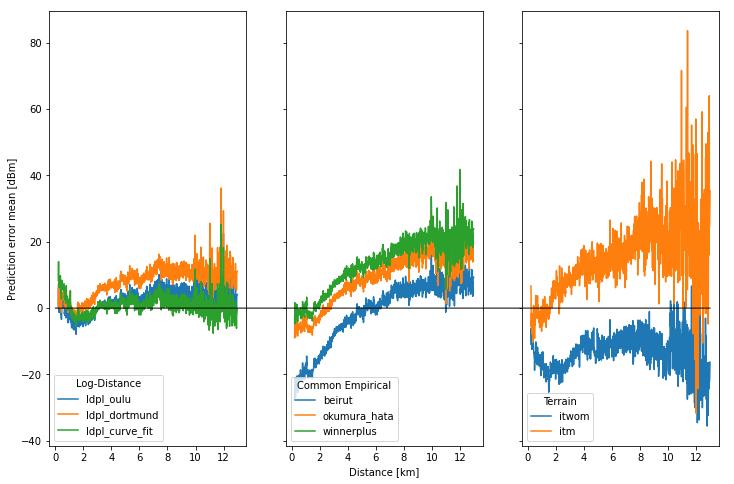

In [18]:
from matplotlib.patches import ConnectionPatch

def plot_skewness_distance():
    group_by_distance = df.groupby(by='gw_distance_rounded_km')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

    def plot_models(fig, ax, title, models):
        for i, pm in enumerate(models):
            ax.plot(group_by_distance.rpp.mean() - (EIRP_AND_RX_GAIN_LOSS-group_by_distance[pm].mean()), label=pm)
        ax.set_xticks(np.arange(0, int(df.gw_distance_rounded_km.max())+1, 2))
        leg = ax.legend(loc='lower left', title=title)

    plot_models(fig, ax1, 'Log-Distance', ['ldpl_oulu', 'ldpl_dortmund', 'ldpl_curve_fit'])
    plot_models(fig, ax2, 'Common Empirical', ['beirut', 'okumura_hata', 'winnerplus'])
    plot_models(fig, ax3, 'Terrain', ['itwom', 'itm'])
    
    dummy = fig.add_subplot(111, frameon=False)
    dummy.grid(False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Distance [km]')
    ax1.set_ylabel('Prediction error mean [dBm]')
    
    dummy.add_artist(ConnectionPatch(xyA=(0.0, 0.0), xyB=(13,0), 
            coordsA="data", coordsB="data", axesA=ax1, axesB=ax3))
    
    plt.show(fig)

plot_skewness_distance()

## Root Mean Squared Error of models

ldpl_curve_fit     9.82
ldpl_oulu         10.05
okumura_hata      10.77
ldpl_dortmund     10.95
winnerplus        11.99
cost_hata         12.41
beirut            16.14
itwom             21.83
egli              22.96
itm               22.96
ecc33             25.23
ericcson          27.55
ldpl_ghent        31.01
fspl              40.89


<AxesSubplot:xlabel='Model', ylabel='RMSE'>

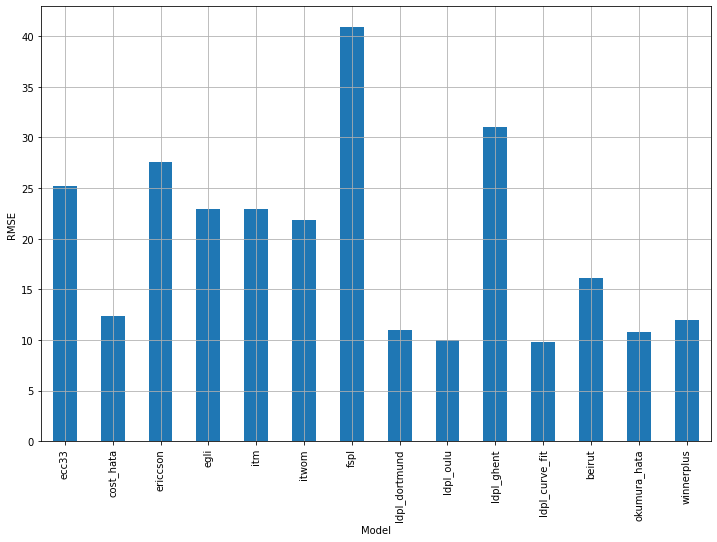

In [19]:
path_loss_models = ['ecc33', 'cost_hata', 'ericcson', 'egli', 'itm', 'itwom', 'fspl', 
                    'ldpl_dortmund', 'ldpl_oulu', 'ldpl_ghent', 'ldpl_curve_fit', 
                    'beirut', 'okumura_hata', 'winnerplus']

rmse = pd.Series( { pm: round(root_mean_squared_error(df.rpp, EIRP_AND_RX_GAIN_LOSS - df[pm]), 2)
                    for pm in path_loss_models } )

print(rmse.sort_values().to_string())
rmse.plot.bar(grid=True, ylabel='RMSE', xlabel='Model')